In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


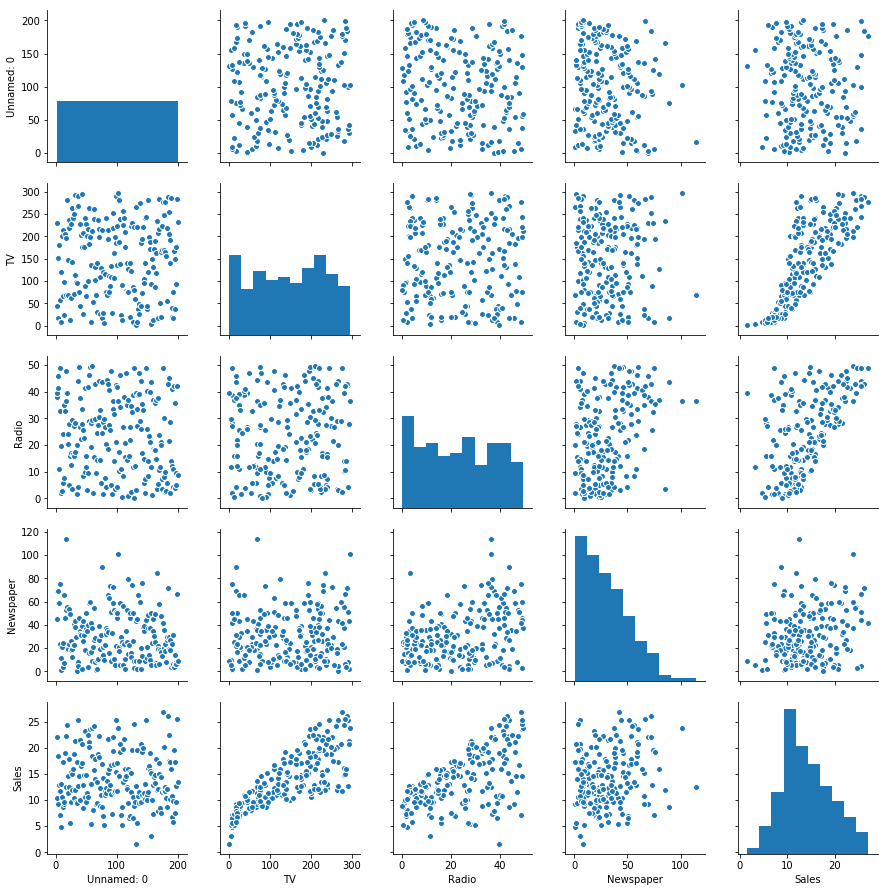

In [3]:
sns.pairplot(data)

* All of the data is inherently non-negative

* Definite nonlinear relationship between TV and Sales

* Let's investigate log transforming all the TV input plus sales (y).

In [4]:
data['logSales'] = np.log(data['Sales']+1)
data['logTV'] = np.log(data['TV']+1)
#data['logRadio'] = np.log(data['Radio']+1)
#data['logNews'] = np.log(data['Newspaper']+1)

In [5]:
# new model for log transform experiment
regr1 = linear_model.LinearRegression()

Y1 = data['logSales'].values.reshape(-1, 1)
X1 = data[['logTV','Radio','Newspaper']]
regr1.fit(X1, Y1)

# Inspect the results.
print('\nCoefficients: \n', regr1.coef_)
print('\nIntercept: \n', regr1.intercept_)
print('\nR-squared:')
print(regr1.score(X1, Y1))


Coefficients: 
 [[3.32977990e-01 1.23976511e-02 1.28718198e-04]]

Intercept: 
 [0.78972687]

R-squared:
0.9692559387091811


* This works great.

* Large improvement in R^2.

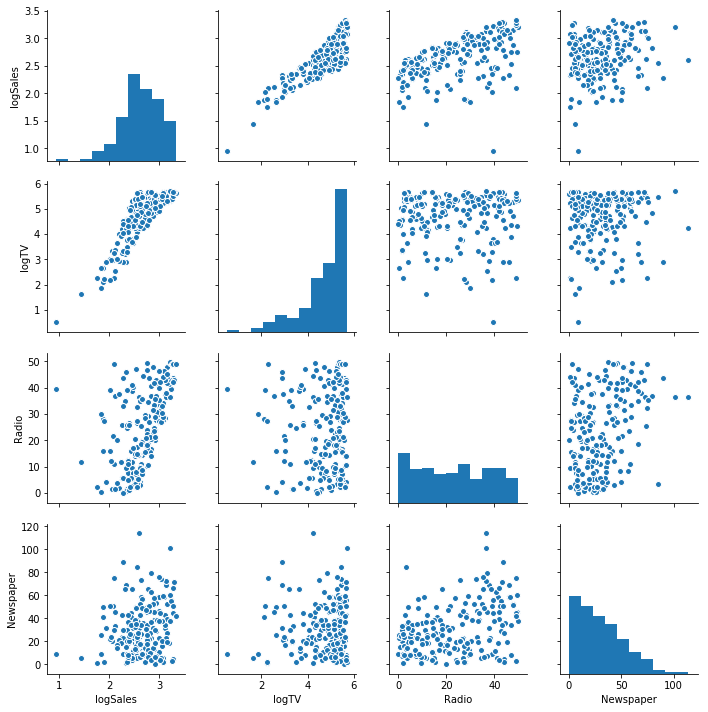

In [6]:
sns.pairplot(data[['logSales','logTV','Radio','Newspaper']])
plt.show()

* Seems to fix most of the nonlinearity between Sales and TV expenditures.

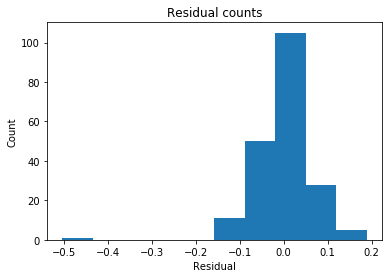

In [11]:
# Extract predicted values.
predicted = regr1.predict(X1).ravel()
actual = data['logSales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

* There is a definite improvement in normality of residuals

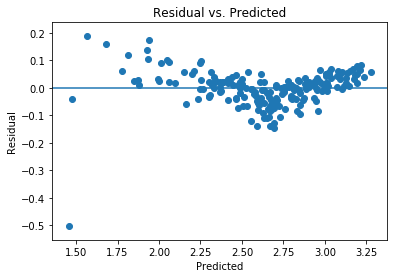

In [12]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


* still has a U-shaped look

* High predicted logSales tends to have positive biased residuals

* Low predicted logSales is also associated with positve biased residuals .

* LogSales predictions that are in the middle tend to have negative residuals.

* We can try product interactions as additional predictors in a second model.

In [13]:
# make product interactions
data['TV*Radio'] = data['logTV']*data['Radio']
data['TV*News'] = data['logTV']*data['Newspaper']
data['Radio*News'] = data['Radio']*data['Newspaper']
data['TV*Radio*News'] = data['logTV']*data['Radio']*data['Newspaper']

In [17]:
regr2 = linear_model.LinearRegression()

Y2 = data['logSales'].values.reshape(-1, 1)
X2 = data[['logTV','Radio','Newspaper','TV*Radio','TV*News','Radio*News','TV*Radio*News']]
#X2 = data[['logTV','Radio','Newspaper','TV*Radio']]
regr2.fit(X2, Y2)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y2))


Coefficients: 
 [[ 2.41088112e-01 -8.04161048e-03  6.37971154e-04  4.34213939e-03
  -9.63979075e-05  9.60050237e-05 -2.03771103e-05]]

Intercept: 
 [1.22084391]

R-squared:
0.9872771920083285


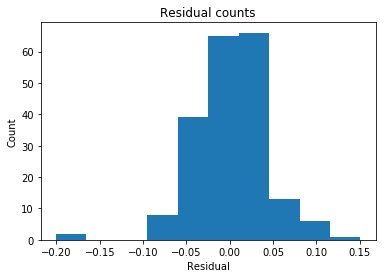

In [18]:
# Extract predicted values.
predicted = regr2.predict(X2).ravel()
actual = data['logSales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

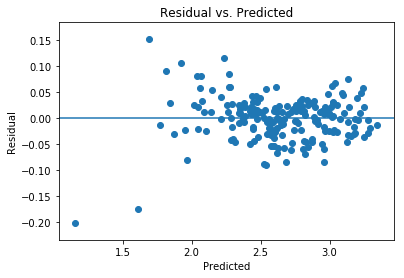

In [19]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


* There seems to be terrible residuals at low predicted sales.

* Looking at the pairplots, we see that the association breaks down at low values of the logTV variable.

* Let's add a dummy variable for low values of logTV.

In [61]:
data['lowTV'] = np.where(data['logTV'] < 1.8,1,0)
data['highNews'] = np.where(data['Newspaper'] > 90,1,0)
data['lowNews'] = np.where(data['Newspaper'] < 10,1,0)

In [63]:
regr3 = linear_model.LinearRegression()

Y3 = data['logSales'].values.reshape(-1, 1)
X3 = data[['logTV','Radio','Newspaper','TV*Radio','TV*News','Radio*News','TV*Radio*News','lowTV','lowNews','highNews']]


regr3.fit(X3, Y3)

# Inspect the results.
print('\nCoefficients: \n', regr3.coef_)
print('\nIntercept: \n', regr3.intercept_)
print('\nR-squared:')
print(regr3.score(X3, Y3))


Coefficients: 
 [[ 2.22158030e-01 -6.77652867e-03 -2.59142853e-03  4.07045095e-03
   5.49986121e-04  1.19088732e-04 -2.43901538e-05 -2.78736432e-01
   7.02786032e-03 -7.09660595e-03]]

Intercept: 
 [1.31326638]

R-squared:
0.9910076765561135


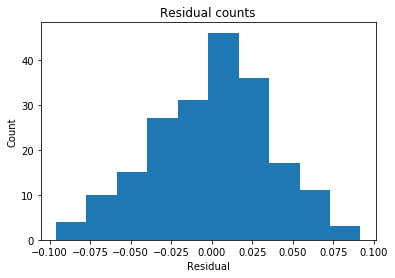

In [64]:
# Extract predicted values.
predicted = regr3.predict(X3).ravel()
actual = data['logSales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

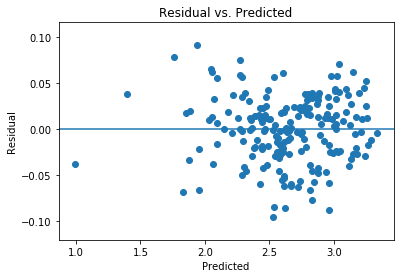

In [65]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

* Residuals look much better and we have an R^2 of over .991.